# Try Diffusion Model
[reference](https://www.peterholderrieth.com/blog/2023/Diffusion-Models-From-Scratch-1d-Manifold/)

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import utils
from torch.utils.data import Dataset, DataLoader

def manifold_func(x):
    return x**2

N_samples = 10000
x = torch.rand(N_samples)
y = manifold_func(x)
data = torch.stack([x,y],axis=1)

In [6]:

class ManifoldDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        super().__init__()
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

dataset = ManifoldDataset(data)
batch_size = 128
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
vpsde = utils.VPSDE(T_max=1, beta_min=0.01, beta_max=2.0)

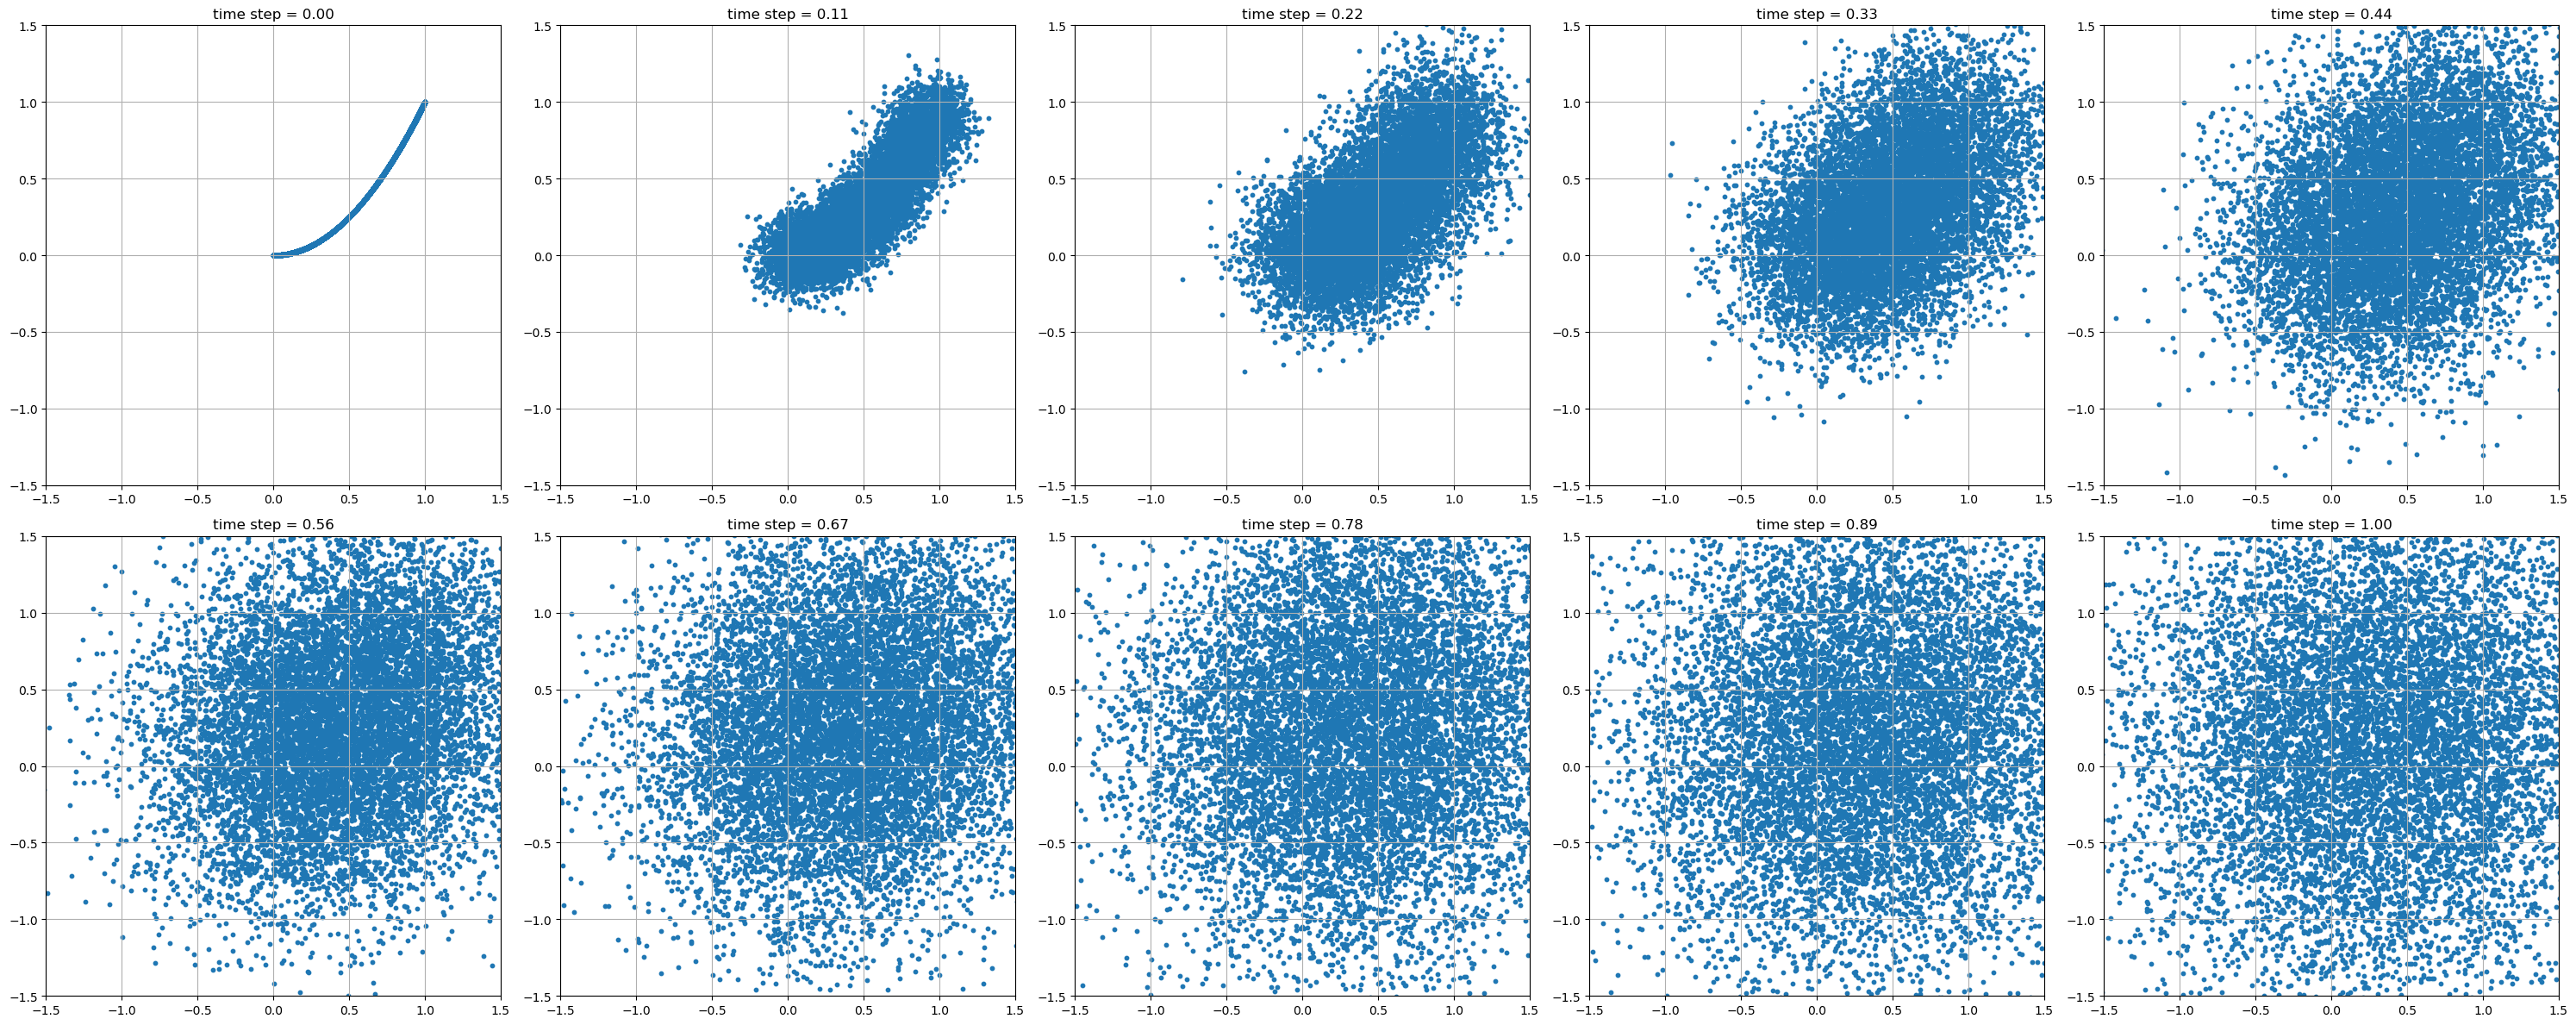

In [8]:
n_time_slides = 10
t = torch.linspace(0, 1, n_time_slides)
X_0 = torch.stack([torch.stack([dataset[idx]]*n_time_slides) for idx in range(10000)]).transpose(1, 0)
X_t, noise, score = vpsde.run_forward(X_0, t)
fig, axs = plt.subplots(2, n_time_slides//2, figsize=(3 * n_time_slides, 12))

for idx in range(n_time_slides):
    row = idx // 5
    col = idx % 5
    axs[row, col].scatter(X_t[idx, :, 0], X_t[idx, :, 1], s=10) 
    axs[row, col].set_xlim(-1.5, 1.5)
    axs[row, col].set_ylim(-1.5, 1.5)
    axs[row, col].set_title(f"time step = {t[idx]:.2f}")
    axs[row, col].grid(True)  
plt.tight_layout()
plt.show()

In [11]:

class FCNScoreModel(nn.Module):
    def __init__(self, input_size: int=2, hidden_size: int=128, n_hidden_layers: int=4):
        super().__init__()
        self.input_layer = nn.Linear(input_size + 1, hidden_size)
        self.input_batch_norm = nn.BatchNorm1d(hidden_size)
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_hidden_layers):
            layer = nn.Linear(hidden_size, hidden_size)
            batch_norm = nn.BatchNorm1d(hidden_size)
            self.hidden_layers.append(nn.Sequential(layer, batch_norm))
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        input = torch.concat([x, t.unsqueeze(1)], dim=1)
        x = F.relu(self.input_batch_norm(self.input_layer(input)))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        return self.output_layer(x)
    
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FCNScoreModel().to(device)
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-5
N_EPOCHS = 100

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, maximize=False)


In [12]:
def train(model, sde: utils.ItoSDE, dataloader: DataLoader, 
          optimizer, device, scheduler: None, n_epochs: int, train_score: bool=False):
    model.train()
    loss_function = nn.MSELoss(reduction='mean')
    loss_list = []
    
    for epoch in range(n_epochs):
        epoch_losses = []
        for idx, X_0 in enumerate(dataloader):
            optimizer.zero_grad()
            X_t, noise, score, time = sde.run_forward_random_time(X_0)
            X_t = X_t.to(device)
            noise = noise.to(device)
            time = time.to(device)
            score = score.to(device)
            
            score_pred = model(X_t, time)
            loss = loss_function(score if train_score else noise, score_pred)
            
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.detach().item())
            
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        loss_list.append(avg_loss)
        print(f"Epoch {epoch}: Average Loss = {avg_loss:.6f}")
        
        if scheduler:
            scheduler.step()
            
    return model, loss_list
model, loss_list = train(model=model, sde=vpsde, dataloader=trainloader, scheduler=None, optimizer=optimizer, device=device, n_epochs=N_EPOCHS)

Epoch 0: Average Loss = 0.340100
Epoch 1: Average Loss = 0.263188
Epoch 2: Average Loss = 0.268697
Epoch 3: Average Loss = 0.259135
Epoch 4: Average Loss = 0.263443
Epoch 5: Average Loss = 0.267269
Epoch 6: Average Loss = 0.262811
Epoch 7: Average Loss = 0.261019
Epoch 8: Average Loss = 0.251839
Epoch 9: Average Loss = 0.248059
Epoch 10: Average Loss = 0.251347
Epoch 11: Average Loss = 0.256377
Epoch 12: Average Loss = 0.249941
Epoch 13: Average Loss = 0.250867
Epoch 14: Average Loss = 0.248923
Epoch 15: Average Loss = 0.254035
Epoch 16: Average Loss = 0.242444
Epoch 17: Average Loss = 0.249705
Epoch 18: Average Loss = 0.245512
Epoch 19: Average Loss = 0.246098
Epoch 20: Average Loss = 0.245969
Epoch 21: Average Loss = 0.260398
Epoch 22: Average Loss = 0.248727
Epoch 23: Average Loss = 0.252622
Epoch 24: Average Loss = 0.249018
Epoch 25: Average Loss = 0.244691
Epoch 26: Average Loss = 0.259060
Epoch 27: Average Loss = 0.254827
Epoch 28: Average Loss = 0.252143
Epoch 29: Average Loss =

d:\Anaconda\envs\pytorch\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Axes: >

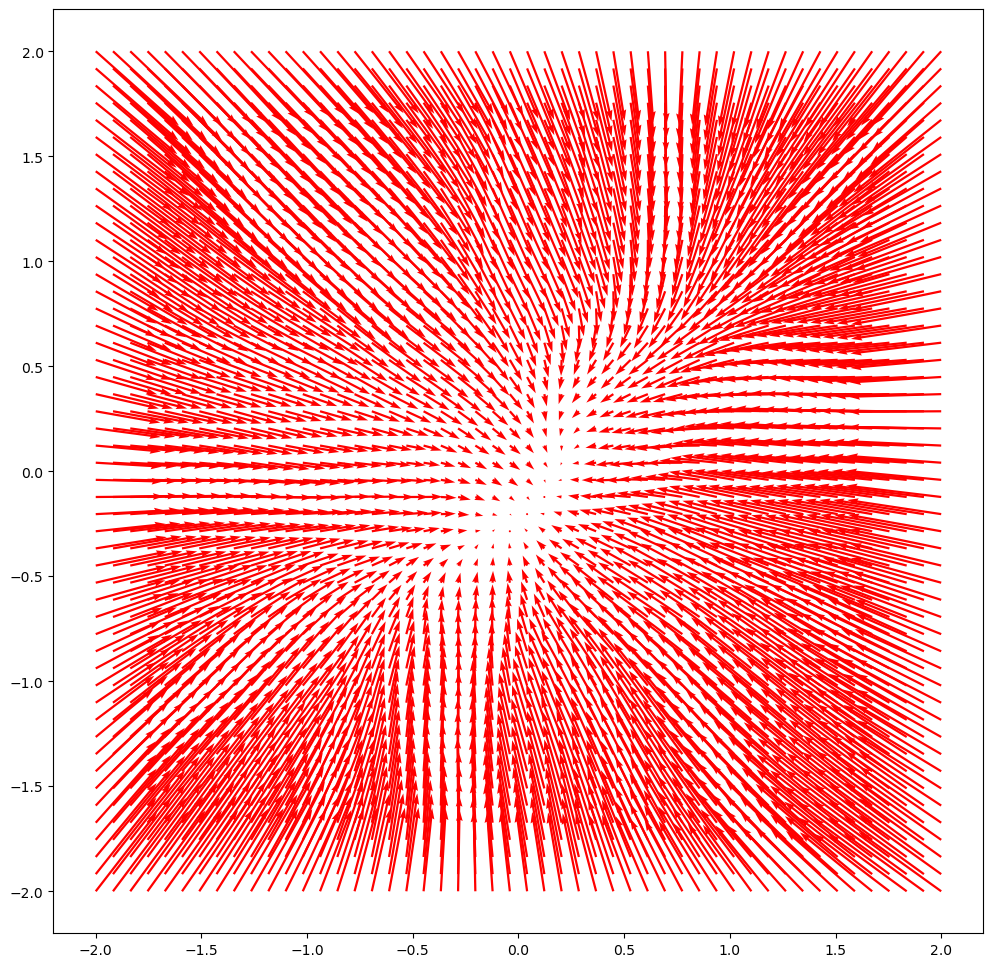

In [11]:
from typing import List, Callable
from itertools import product
def plot_score_vector_field(score_func: Callable, t: torch.Tensor, sde: utils.ItoSDE, min_x: float = -2.0, max_x: float = 2.0, n_grid_points: int = 50):
    oned_grid = torch.linspace(min_x, max_x, n_grid_points)
    x_grid, y_grid = torch.meshgrid(oned_grid, oned_grid)
    twod_grid = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)
    cond_std = sde.cond_var(twod_grid, t)
    t = t.expand(twod_grid.shape[0])
    extent = [oned_grid.min(), oned_grid.max(), oned_grid.min(), oned_grid.max()]
    score = -score_func(x=twod_grid, t=t)/cond_std
    score = score.detach().numpy()

    fig, my_axis = plt.subplots(figsize=(12,12))
    my_axis.quiver(twod_grid[:,0],twod_grid[:,1],score[:,0],score[:,1], scale=100000.0, color='r')
    return my_axis
model = model.to('cpu')
plot_score_vector_field(score_func=model, t=torch.tensor(0.01), sde=vpsde)

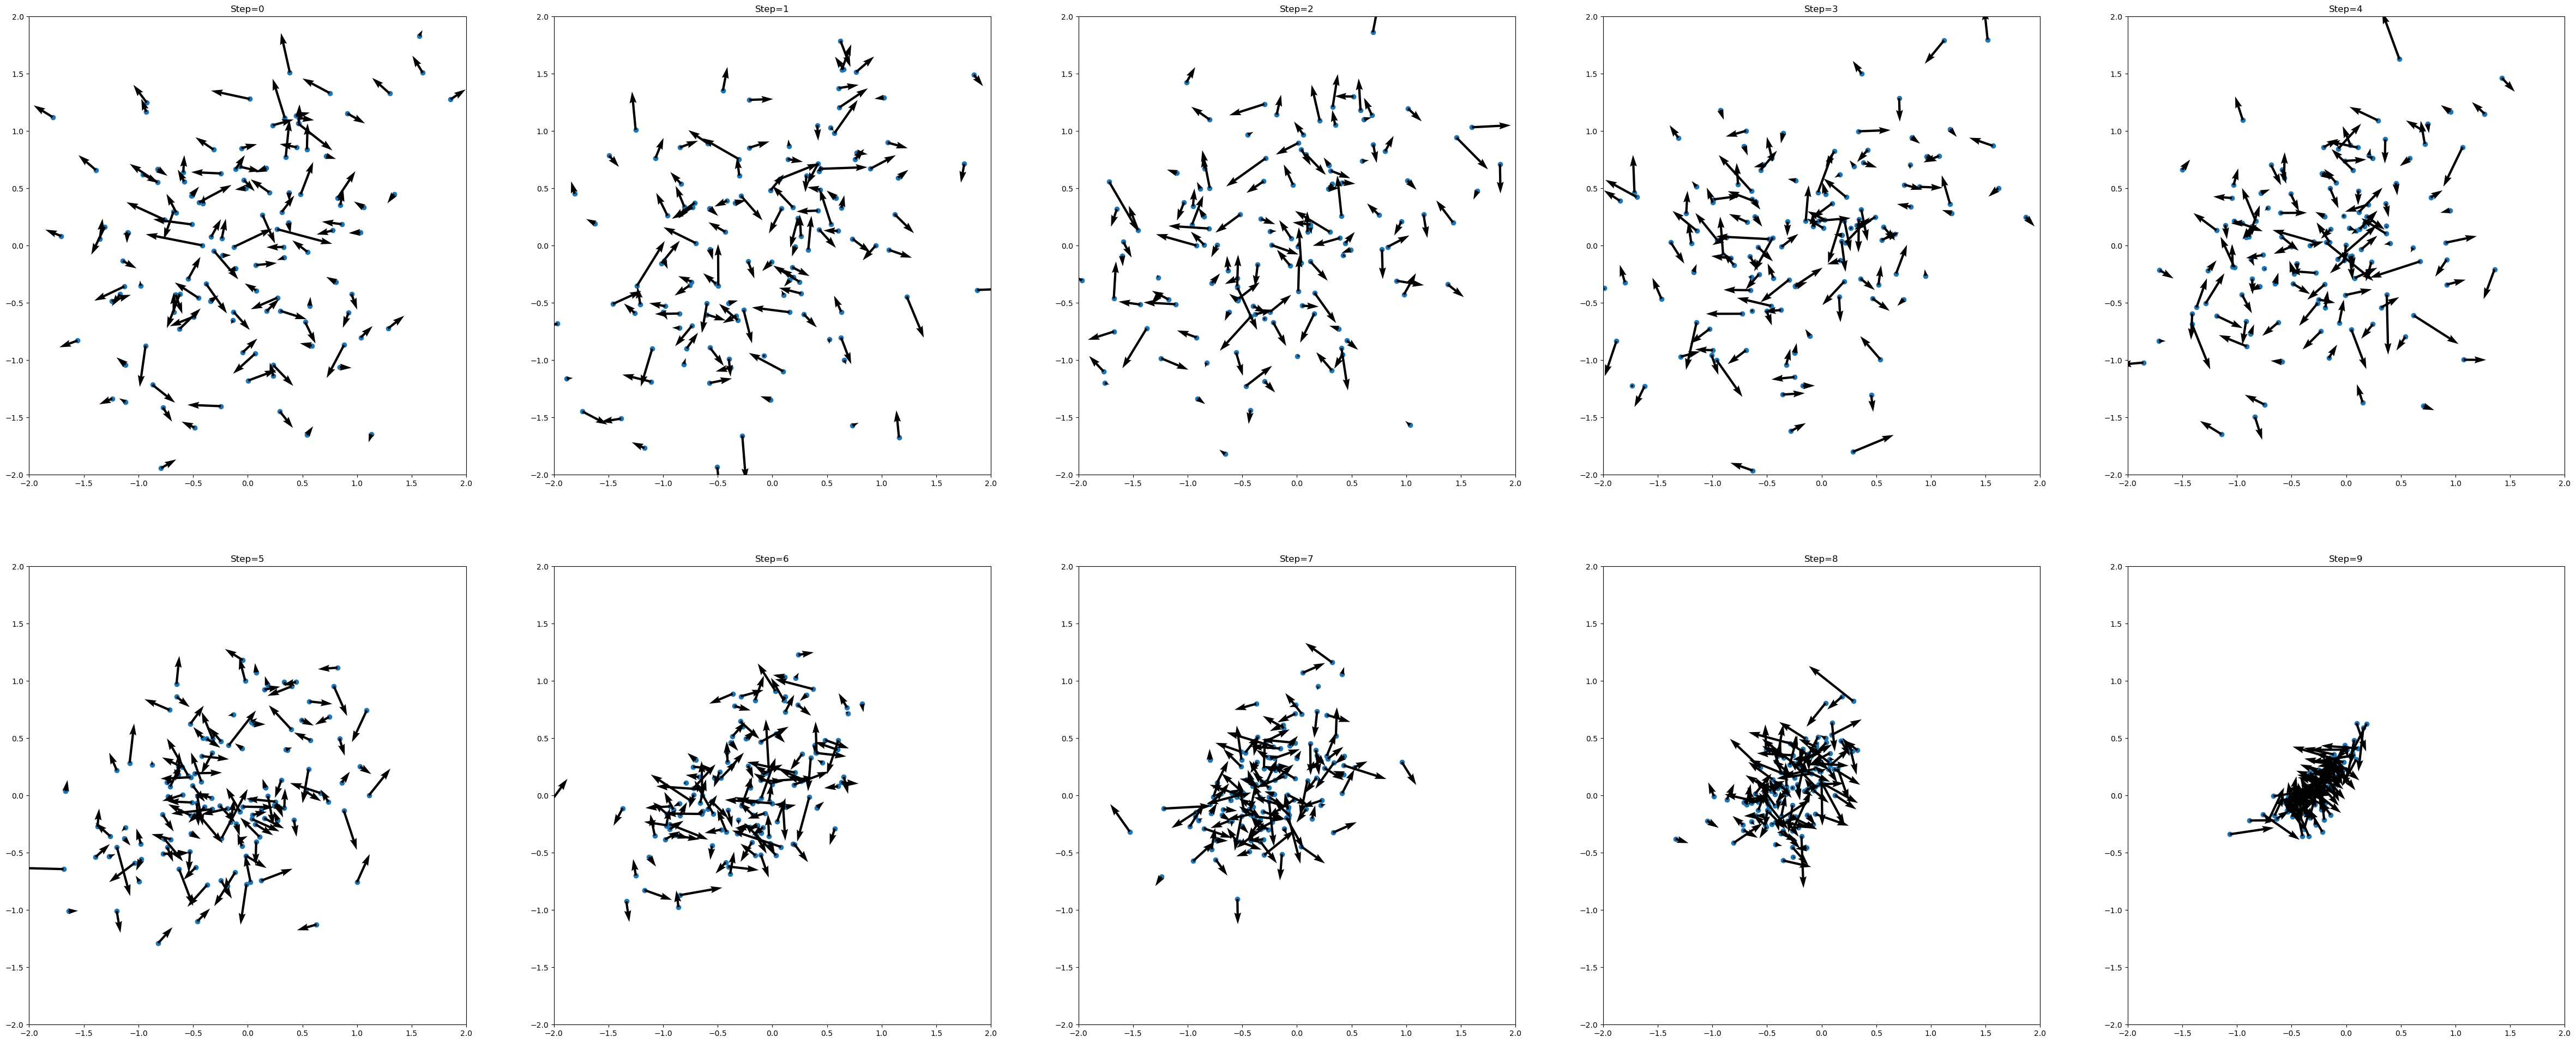

In [14]:
def run_backwards(model: torch.nn.Module, sde: utils.ItoSDE, X_0: torch.Tensor, device, train_score: bool=False, n_steps: int=10, plot_evolution: bool=True):
    model = model.to(device)
    n_traj = X_0.shape[0]
    time_grid = torch.linspace(sde.T_max, 0, n_steps)
    dt = torch.abs(time_grid[0] - time_grid[1])
    diffusion_g = sde.g_random(t=time_grid)
    noise = torch.randn(size=(n_steps, *list(X_0.shape)))
    diffusion_term_grid = utils.mult_first_dim(noise, torch.sqrt(dt) * diffusion_g)
    x_traj = [X_0]
    if plot_evolution:
        n_col = len(time_grid)//2
        fig, axs = plt.subplots(2, n_col,figsize=(12*n_col, 24))
    for idx, t in enumerate(time_grid):
        x = x_traj[idx]
        t = t.repeat(n_traj)
        drift_term = sde.f_drift(x, t) * dt
        diffusion_term = diffusion_term_grid[idx]
        model_estimate = model(x.to(device), t.to(device)).detach().to('cpu')
        if train_score:
            score_estimates = model_estimate
        else:
            denominator = torch.clip(sde.cond_std(None, t), 0.01)
            score_estimates = -utils.mult_first_dim(model_estimate, 1/denominator)
        g_squared = (diffusion_g[idx] ** 2).repeat(n_traj)
        
        correction_term = dt * utils.mult_first_dim(score_estimates, g_squared)
        change = (correction_term - drift_term) + diffusion_term
        x_next = x + change
        x_traj.append(x_next)
        if plot_evolution:
            row = idx // n_col
            col = idx % n_col
            axs[row, col].scatter(x_next[:,0], x_next[:,1])
            axs[row, col].quiver(x_next[:,0], x_next[:,1], change[:,0],change[:,1])
            axs[row, col].set_xlim(-2.0,2.0)
            axs[row, col].set_ylim(-2.0,2.0)
            axs[row, col].set_title(f"Step={idx}")
    output = torch.stack(x_traj)
    return output, time_grid

x_start = torch.randn(size=next(enumerate(trainloader))[1].shape)
output, time_grid = run_backwards(model=model, sde=vpsde, X_0=x_start, device=device)